In [495]:
#langgraph using llm and rag

In [494]:
from pydantic import BaseModel,Field
from langchain.output_parsers import PydanticOutputParser

In [456]:
from typing import Annotated

In [457]:
class outputparser(BaseModel):
    topic:str=Field(description="selected topic")
    reasoning:str=Field(description="reasoning behind the topic")

In [458]:
parser=PydanticOutputParser(pydantic_object=outputparser)

In [459]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "reasoning": {"description": "reasoning behind the topic", "title": "Reasoning", "type": "string"}}, "required": ["topic", "reasoning"]}\n```'

In [460]:
from typing import TypedDict,Annotated,Sequence

In [461]:
from langchain_core.messages import BaseMessage

In [462]:
import operator

In [463]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [464]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [465]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [466]:
from langchain_groq import ChatGroq

In [467]:
llm=ChatGroq(model="gemma2-9b-it")

In [468]:
from langchain import PromptTemplate

In [469]:
from langchain_core.output_parsers import StrOutputParser

In [470]:
def function_1(state):
    print("--> ensure topic <--")
    messages=state["messages"]
    question=messages[-1]

    template="""
        your task is to classify the given user query into one of the following category[langsmith,not Related]
        only response with category and nothing else
        user query:{question},
        {format_instruction}
    """

    prompt=PromptTemplate(
        input_variables=[question],
        template=template,
        format_instruction=parser.get_format_instructions()
    )

    chain=prompt|llm|StrOutputParser()

    response=chain.invoke({"question":question,"format_instruction":parser.get_format_instructions()})

    return {"messages":[response]}

In [471]:
#state={"messages":["who is president of india"]}

In [472]:
#function_1(state)

In [473]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate

In [474]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [475]:
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

In [476]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [477]:
loader=PyPDFLoader("C:\\Users\\user\\OneDrive\\Desktop\\langchain\\temp.pdf")
docs=loader.load()

In [478]:
documets=RecursiveCharacterTextSplitter(chunk_size=400,chunk_overlap=50).split_documents(docs)

In [479]:
documets

[Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langchain\\temp.pdf', 'page': 0}, page_content='From Wikipedia, the free encyclopedia \nAn illustration of main components of the \ntransformer model from the paper \n"Attention Is All You Need"[1] is a 2017 landmark[2][3] research paper in machine learning authored by \neight scientists working at Google. The paper introduced a new deep learning architecture known as'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langchain\\temp.pdf', 'page': 0}, page_content='the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al.[4] It is \nconsidered a foundational[5] paper in modern artificial intelligence, as the transformer approach has \nbecome the main architecture of large language models like those based on GPT.[6][7] At the time, the'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langchain\\temp.pdf', 'page': 0}, page_content='focus of the research w

In [480]:
db=FAISS.from_documents(embedding=embeddings,documents=documets)

In [481]:
retriever=db.as_retriever()

In [482]:
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000207895B52B0>, search_kwargs={})

In [483]:
def router(state):
    print("->calling route <-")

    messages=state["messages"]
    last_message=messages[-1]
    print(last_message)
    if "langsmith" in last_message:
        return "RAG Call"
    else:
        return "LLM Call"

In [484]:
def function_2(state):
    print("-->calling rag <--")
    messages=state["messages"]
    question=messages[0]
    #print(question)
    template="""Answer the following question based on the given context
    {context}
    Question:{question}
    """

    prompt=ChatPromptTemplate.from_template(template)

    retrieval=prompt|llm|StrOutputParser()

    response=retrieval.invoke({"context":retriever,"question":question})

    return {"messages":[response]}

In [485]:
def function_3(state):
    print("-->calling llm <--")
    messages=state["messages"]
    question=messages[0]
    response=llm.invoke(question)
    return {"messages":[response.content]}

In [486]:
from langgraph.graph import StateGraph,END,START

In [487]:
workflow=StateGraph(AgentState)

In [488]:
workflow.add_node("agent",function_1)

workflow.add_node("RAG",function_2)

workflow.add_node("LLM",function_3)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",

    router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
    }
)

workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

In [489]:
graph=workflow.compile()

In [490]:
from IPython.display import display,Image

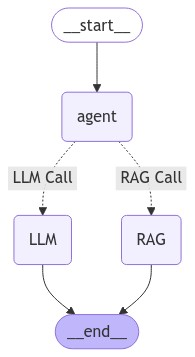

In [491]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [492]:
input={"messages":["give some motivation for college students"]}

In [493]:
graph.invoke(input)

--> ensure topic <--
->calling route <-
{"topic": "not Related", "reasoning": "The query is seeking general motivation, not related to language modeling"} 

-->calling llm <--


{'messages': ['give some motivation for college students',
  '{"topic": "not Related", "reasoning": "The query is seeking general motivation, not related to language modeling"} \n',
  '##  Fueling Your College Fire: Motivation for the Journey\n\nCollege can be a whirlwind of excitement, challenges, and self-discovery.  Here\'s some fuel to keep your fire burning bright:\n\n**Remember Your "Why":**\n\n* **Passion:** What ignited your desire for higher education?  Reconnect with that spark, whether it\'s a specific field, a thirst for knowledge, or a dream you\'re chasing.\n* **Impact:**  How will your education empower you to make a difference in the world?  Visualize the positive impact you can have on your community, your career, or even the lives of others.\n* **Growth:** College isn\'t just about grades; it\'s about personal and intellectual growth. Embrace the opportunities to learn new things, challenge your beliefs, and expand your horizons.\n\n**Navigate the Challenges:**\n\n* *